# Process the Unsplash dataset with CLIP

This notebook processes all the downloaded photos using OpenAI's [CLIP neural network](https://github.com/openai/CLIP). For each image we get a feature vector containing 512 float numbers, which we will store in a file. These feature vectors will be used later to compare them to the text feature vectors.

This step will be significantly faster if you have a GPU, but it will also work on the CPU.

## Load the photos

Load all photos from the folder they were stored.

In [1]:
import datasets
from sentence_transformers import SentenceTransformer
import rich
from IPython.display import Image, JSON
from IPython.core.display import HTML
import numpy as np

In [2]:
dset = datasets.load_from_disk("../data/processed")

In [3]:
def read_image(record, base_path:str):
    image = None
    try:
        image_path = f"{base_path}/{record['image_name']}"
        
        image = PIL.Image.open(image_path)

    except Exception as e:
        print (e)
        
        
    record['image' ] = image
    return record


In [4]:
dset

Dataset({
    features: ['photo_id', 'photo_url', 'photo_image_url', 'photo_submitted_at', 'photo_featured', 'photo_width', 'photo_height', 'photo_aspect_ratio', 'photo_description', 'photographer_username', 'photographer_first_name', 'photographer_last_name', 'exif_camera_make', 'exif_camera_model', 'exif_iso', 'exif_aperture_value', 'exif_focal_length', 'exif_exposure_time', 'photo_location_name', 'photo_location_latitude', 'photo_location_longitude', 'photo_location_country', 'photo_location_city', 'stats_views', 'stats_downloads', 'ai_description', 'ai_primary_landmark_name', 'ai_primary_landmark_latitude', 'ai_primary_landmark_longitude', 'ai_primary_landmark_confidence', 'blur_hash', 'description_final', 'image'],
    num_rows: 24995
})

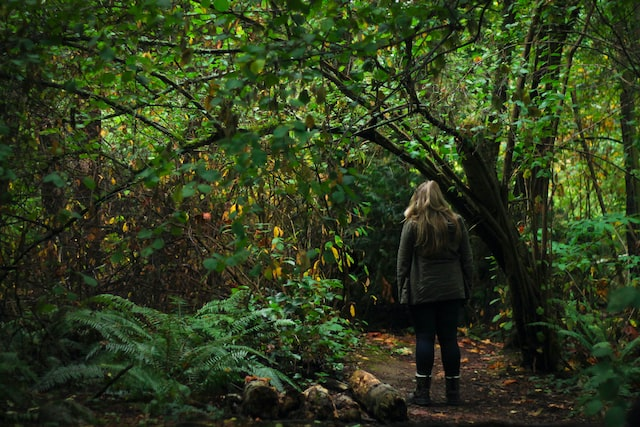

In [5]:
dset[0]['image']

In [6]:
model = SentenceTransformer('clip-ViT-B-32')

In [7]:
# ds_with_embeddings = dset.map(
#     lambda example: {'embeddings':model.encode(example['image'], device='cpu', normalize_embeddings=False)}, batched=True, batch_size=32)

# ds_with_embeddings.save_to_disk("../data/processed_embeddings")


ds_with_embeddings = datasets.load_from_disk("../data/processed_embeddings")

In [8]:
corpus = ds_with_embeddings['embeddings']
corpus = np.array(corpus)

In [9]:
ds_with_embeddings

Dataset({
    features: ['photo_id', 'photo_url', 'photo_image_url', 'photo_submitted_at', 'photo_featured', 'photo_width', 'photo_height', 'photo_aspect_ratio', 'photo_description', 'photographer_username', 'photographer_first_name', 'photographer_last_name', 'exif_camera_make', 'exif_camera_model', 'exif_iso', 'exif_aperture_value', 'exif_focal_length', 'exif_exposure_time', 'photo_location_name', 'photo_location_latitude', 'photo_location_longitude', 'photo_location_country', 'photo_location_city', 'stats_views', 'stats_downloads', 'ai_description', 'ai_primary_landmark_name', 'ai_primary_landmark_latitude', 'ai_primary_landmark_longitude', 'ai_primary_landmark_confidence', 'blur_hash', 'description_final', 'image', 'embeddings'],
    num_rows: 24995
})

In [10]:
dset = ds_with_embeddings

In [11]:
type(corpus)

numpy.ndarray

In [12]:
def find_results(query:str , k =5):
    
    
    query_features = model.encode(query)
    doc_scores = query_features @ corpus.T

    top_items = doc_scores.argsort()[-k:][::-1]



    degug_info = {
         "query_original":  query 
         , "query_processed" : query_features
        , "doc_scores":  doc_scores 
        , "top_items":  top_items 
    }
    #rich.print (degug_info )
    

    display(HTML(f"<h1>Query: {query} </h1>"))
    
    # Iterate over the top k results
    for idx, photo_data in enumerate( ds_with_embeddings.select(top_items)):

        doc_idx = top_items[idx]
        # Display the photo
        display(Image(url=photo_data["photo_image_url"] + "?w=200"))

        # Display the attribution text
        display(HTML(f"""
                     Photo title: {photo_data["description_final"]}   <br/>
                     Photo by <a href="https://unsplash.com/@{photo_data["photographer_username"]}?utm_source=NaturalLanguageImageSearch&utm_medium=referral">{photo_data["photographer_first_name"]} {photo_data["photographer_last_name"]}</a> on <a href="https://unsplash.com/?utm_source=SearchWorkshop&utm_medium=referral">Unsplash</a> <br/>
                     Distance: {doc_scores[doc_idx]}
                     """
                                        ))
        print()

In [13]:
find_results( "Two dogs playing in the snow")

In [14]:
model

SentenceTransformer(
  (0): CLIPModel()
)

In [15]:
find_results( "boy and girl on a beach")

In [16]:
find_results( "image of a man in a desert")

In [17]:
%%timeit
search_query = "Two dogs playing in the snow"
k=5
query_features = model.encode(search_query)
doc_scores = query_features @ corpus.T

top_items = doc_scores.argsort()[-k:][::-1]

103 ms ± 23.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
!ls